In [38]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [39]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [85]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2019):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [41]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 2511
Total Drives: 64609
Total Plays: 455669


In [42]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty"))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

Clean Drives: 44151


In [70]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [99]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.381818,0.072727,4.927273,28.1,3.1,0.75,0.4,0.515152,1.15,0.22,0.547781,0.011873
1,Virginia Tech,34,3,0.124335,0.403226,0.080645,5.629032,26.3,3.4,0.60,0.5,0.487805,0.93,-0.22,0.535908,-0.011873


In [55]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/2511] Getting game information for ESPN game_id: 400869090
[1/2511] Started processing game information for ESPN game_id: 400869090
[1/2511] Completed processing game information for ESPN game_id: 400869090
[1/2511] Aggreggating game_id 400869090 to master data copy
[2/2511] Getting game information for ESPN game_id: 400869421
[2/2511] Started processing game information for ESPN game_id: 400869421
[2/2511] Completed processing game information for ESPN game_id: 400869421
[2/2511] Aggreggating game_id 400869421 to master data copy
[3/2511] Getting game information for ESPN game_id: 400869257
[3/2511] Started processing game information for ESPN game_id: 400869257
[3/2511] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/2511] Getting game information for ESPN game_id: 400869502
[4/2511] Started processing game information for ESPN game_id: 400869502
[4/2511] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/2511] Getting game information for ES

[35/2511] Completed processing game information for ESPN game_id: 400868976
[35/2511] Aggreggating game_id 400868976 to master data copy
[36/2511] Getting game information for ESPN game_id: 400869507
[36/2511] Started processing game information for ESPN game_id: 400869507
[36/2511] Completed processing game information for ESPN game_id: 400869507
[36/2511] Aggreggating game_id 400869507 to master data copy
[37/2511] Getting game information for ESPN game_id: 400869260
[37/2511] Started processing game information for ESPN game_id: 400869260
[37/2511] Completed processing game information for ESPN game_id: 400869260
[37/2511] Aggreggating game_id 400869260 to master data copy
[38/2511] Getting game information for ESPN game_id: 400869509
[38/2511] Started processing game information for ESPN game_id: 400869509
[38/2511] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/2511] Getting game information for ESPN game_id: 400869267
[39/2511] Started processing game infor

[72/2511] Completed processing game information for ESPN game_id: 400868957
[72/2511] Aggreggating game_id 400868957 to master data copy
[73/2511] Getting game information for ESPN game_id: 400869624
[73/2511] Started processing game information for ESPN game_id: 400869624
[73/2511] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/2511] Getting game information for ESPN game_id: 400868969
[74/2511] Started processing game information for ESPN game_id: 400868969
[74/2511] Completed processing game information for ESPN game_id: 400868969
[74/2511] Aggreggating game_id 400868969 to master data copy
[75/2511] Getting game information for ESPN game_id: 400868887
[75/2511] Started processing game information for ESPN game_id: 400868887
[75/2511] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[76/2511] Getting game information for ESPN game_id: 400869179
[76/2511] Started processing game information for ESPN game_id: 400869179
[76/2511] Completed proces

[109/2511] Completed processing game information for ESPN game_id: 400869277
[109/2511] Aggreggating game_id 400869277 to master data copy
[110/2511] Getting game information for ESPN game_id: 400869433
[110/2511] Started processing game information for ESPN game_id: 400869433
[110/2511] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/2511] Getting game information for ESPN game_id: 400868877
[111/2511] Started processing game information for ESPN game_id: 400868877
[111/2511] Completed processing game information for ESPN game_id: 400868877
[111/2511] Aggreggating game_id 400868877 to master data copy
[112/2511] Getting game information for ESPN game_id: 400868980
[112/2511] Started processing game information for ESPN game_id: 400868980
[112/2511] Completed processing game information for ESPN game_id: 400868980
[112/2511] Aggreggating game_id 400868980 to master data copy
[113/2511] Getting game information for ESPN game_id: 400869516
[113/2511] Started proces

[144/2511] Completed processing game information for ESPN game_id: 400868981
[144/2511] Aggreggating game_id 400868981 to master data copy
[145/2511] Getting game information for ESPN game_id: 400869357
[145/2511] Started processing game information for ESPN game_id: 400869357
[145/2511] Completed processing game information for ESPN game_id: 400869357
[145/2511] Aggreggating game_id 400869357 to master data copy
[146/2511] Getting game information for ESPN game_id: 400868888
[146/2511] Started processing game information for ESPN game_id: 400868888
[146/2511] Completed processing game information for ESPN game_id: 400868888
[146/2511] Aggreggating game_id 400868888 to master data copy
[147/2511] Getting game information for ESPN game_id: 400868985
[147/2511] Started processing game information for ESPN game_id: 400868985
[147/2511] Skipping checking game_id 400868985 bc one of the teams isn't FBS
[148/2511] Getting game information for ESPN game_id: 400868982
[148/2511] Started proces

[176/2511] Completed processing game information for ESPN game_id: 400869281
[176/2511] Aggreggating game_id 400869281 to master data copy
[177/2511] Getting game information for ESPN game_id: 400869519
[177/2511] Started processing game information for ESPN game_id: 400869519
[177/2511] Completed processing game information for ESPN game_id: 400869519
[177/2511] Aggreggating game_id 400869519 to master data copy
[178/2511] Getting game information for ESPN game_id: 400869520
[178/2511] Started processing game information for ESPN game_id: 400869520
[178/2511] Completed processing game information for ESPN game_id: 400869520
[178/2511] Aggreggating game_id 400869520 to master data copy
[179/2511] Getting game information for ESPN game_id: 400869001
[179/2511] Started processing game information for ESPN game_id: 400869001
[179/2511] Completed processing game information for ESPN game_id: 400869001
[179/2511] Aggreggating game_id 400869001 to master data copy
[180/2511] Getting game inf

[209/2511] Completed processing game information for ESPN game_id: 400868993
[209/2511] Aggreggating game_id 400868993 to master data copy
[210/2511] Getting game information for ESPN game_id: 400868996
[210/2511] Started processing game information for ESPN game_id: 400868996
[210/2511] Completed processing game information for ESPN game_id: 400868996
[210/2511] Aggreggating game_id 400868996 to master data copy
[211/2511] Getting game information for ESPN game_id: 400869521
[211/2511] Started processing game information for ESPN game_id: 400869521
[211/2511] Completed processing game information for ESPN game_id: 400869521
[211/2511] Aggreggating game_id 400869521 to master data copy
[212/2511] Getting game information for ESPN game_id: 400869522
[212/2511] Started processing game information for ESPN game_id: 400869522
Could not find drive data for game_id 400869522 locally, checking CFB Data API
Could not find drive data for game_id 400869522 bc of issues with 2016 data source, bai

[241/2511] Completed processing game information for ESPN game_id: 400869204
[241/2511] Aggreggating game_id 400869204 to master data copy
[242/2511] Getting game information for ESPN game_id: 400869203
[242/2511] Started processing game information for ESPN game_id: 400869203
[242/2511] Completed processing game information for ESPN game_id: 400869203
[242/2511] Aggreggating game_id 400869203 to master data copy
[243/2511] Getting game information for ESPN game_id: 400869288
[243/2511] Started processing game information for ESPN game_id: 400869288
[243/2511] Completed processing game information for ESPN game_id: 400869288
[243/2511] Aggreggating game_id 400869288 to master data copy
[244/2511] Getting game information for ESPN game_id: 400869451
[244/2511] Started processing game information for ESPN game_id: 400869451
[244/2511] Completed processing game information for ESPN game_id: 400869451
[244/2511] Aggreggating game_id 400869451 to master data copy
[245/2511] Getting game inf

[273/2511] Completed processing game information for ESPN game_id: 400868913
[273/2511] Aggreggating game_id 400868913 to master data copy
[274/2511] Getting game information for ESPN game_id: 400869815
[274/2511] Started processing game information for ESPN game_id: 400869815
[274/2511] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/2511] Getting game information for ESPN game_id: 400869605
[275/2511] Started processing game information for ESPN game_id: 400869605
[275/2511] Skipping checking game_id 400869605 bc one of the teams isn't FBS
[276/2511] Getting game information for ESPN game_id: 400869004
[276/2511] Started processing game information for ESPN game_id: 400869004
[276/2511] Completed processing game information for ESPN game_id: 400869004
[276/2511] Aggreggating game_id 400869004 to master data copy
[277/2511] Getting game information for ESPN game_id: 400869660
[277/2511] Started processing game information for ESPN game_id: 400869660
[277/2511] C

[304/2511] Completed processing game information for ESPN game_id: 400869454
[304/2511] Aggreggating game_id 400869454 to master data copy
[305/2511] Getting game information for ESPN game_id: 400869294
[305/2511] Started processing game information for ESPN game_id: 400869294
[305/2511] Completed processing game information for ESPN game_id: 400869294
[305/2511] Aggreggating game_id 400869294 to master data copy
[306/2511] Getting game information for ESPN game_id: 400869296
[306/2511] Started processing game information for ESPN game_id: 400869296
[306/2511] Completed processing game information for ESPN game_id: 400869296
[306/2511] Aggreggating game_id 400869296 to master data copy
[307/2511] Getting game information for ESPN game_id: 400869127
[307/2511] Started processing game information for ESPN game_id: 400869127
[307/2511] Completed processing game information for ESPN game_id: 400869127
[307/2511] Aggreggating game_id 400869127 to master data copy
[308/2511] Getting game inf

[334/2511] Completed processing game information for ESPN game_id: 400869371
[334/2511] Aggreggating game_id 400869371 to master data copy
[335/2511] Getting game information for ESPN game_id: 400869010
[335/2511] Started processing game information for ESPN game_id: 400869010
[335/2511] Completed processing game information for ESPN game_id: 400869010
[335/2511] Aggreggating game_id 400869010 to master data copy
[336/2511] Getting game information for ESPN game_id: 400869374
[336/2511] Started processing game information for ESPN game_id: 400869374
[336/2511] Completed processing game information for ESPN game_id: 400869374
[336/2511] Aggreggating game_id 400869374 to master data copy
[337/2511] Getting game information for ESPN game_id: 400869014
[337/2511] Started processing game information for ESPN game_id: 400869014
[337/2511] Completed processing game information for ESPN game_id: 400869014
[337/2511] Aggreggating game_id 400869014 to master data copy
[338/2511] Getting game inf

[365/2511] Completed processing game information for ESPN game_id: 400869021
[365/2511] Aggreggating game_id 400869021 to master data copy
[366/2511] Getting game information for ESPN game_id: 400868951
[366/2511] Started processing game information for ESPN game_id: 400868951
[366/2511] Completed processing game information for ESPN game_id: 400868951
[366/2511] Aggreggating game_id 400868951 to master data copy
[367/2511] Getting game information for ESPN game_id: 400869458
[367/2511] Started processing game information for ESPN game_id: 400869458
[367/2511] Completed processing game information for ESPN game_id: 400869458
[367/2511] Aggreggating game_id 400869458 to master data copy
[368/2511] Getting game information for ESPN game_id: 400869300
[368/2511] Started processing game information for ESPN game_id: 400869300
[368/2511] Completed processing game information for ESPN game_id: 400869300
[368/2511] Aggreggating game_id 400869300 to master data copy
[369/2511] Getting game inf

[397/2511] Completed processing game information for ESPN game_id: 400869134
[397/2511] Aggreggating game_id 400869134 to master data copy
[398/2511] Getting game information for ESPN game_id: 400869130
[398/2511] Started processing game information for ESPN game_id: 400869130
[398/2511] Completed processing game information for ESPN game_id: 400869130
[398/2511] Aggreggating game_id 400869130 to master data copy
[399/2511] Getting game information for ESPN game_id: 400869215
[399/2511] Started processing game information for ESPN game_id: 400869215
[399/2511] Completed processing game information for ESPN game_id: 400869215
[399/2511] Aggreggating game_id 400869215 to master data copy
[400/2511] Getting game information for ESPN game_id: 400869218
[400/2511] Started processing game information for ESPN game_id: 400869218
[400/2511] Completed processing game information for ESPN game_id: 400869218
[400/2511] Aggreggating game_id 400869218 to master data copy
[401/2511] Getting game inf

[428/2511] Completed processing game information for ESPN game_id: 400869672
[428/2511] Aggreggating game_id 400869672 to master data copy
[429/2511] Getting game information for ESPN game_id: 400869827
[429/2511] Started processing game information for ESPN game_id: 400869827
[429/2511] Completed processing game information for ESPN game_id: 400869827
[429/2511] Aggreggating game_id 400869827 to master data copy
[430/2511] Getting game information for ESPN game_id: 400869028
[430/2511] Started processing game information for ESPN game_id: 400869028
[430/2511] Completed processing game information for ESPN game_id: 400869028
[430/2511] Aggreggating game_id 400869028 to master data copy
[431/2511] Getting game information for ESPN game_id: 400869463
[431/2511] Started processing game information for ESPN game_id: 400869463
[431/2511] Completed processing game information for ESPN game_id: 400869463
[431/2511] Aggreggating game_id 400869463 to master data copy
[432/2511] Getting game inf

[458/2511] Completed processing game information for ESPN game_id: 400869222
[458/2511] Aggreggating game_id 400869222 to master data copy
[459/2511] Getting game information for ESPN game_id: 400869467
[459/2511] Started processing game information for ESPN game_id: 400869467
[459/2511] Completed processing game information for ESPN game_id: 400869467
[459/2511] Aggreggating game_id 400869467 to master data copy
[460/2511] Getting game information for ESPN game_id: 400869830
[460/2511] Started processing game information for ESPN game_id: 400869830
[460/2511] Completed processing game information for ESPN game_id: 400869830
[460/2511] Aggreggating game_id 400869830 to master data copy
[461/2511] Getting game information for ESPN game_id: 400869224
[461/2511] Started processing game information for ESPN game_id: 400869224
[461/2511] Completed processing game information for ESPN game_id: 400869224
[461/2511] Aggreggating game_id 400869224 to master data copy
[462/2511] Getting game inf

[491/2511] Completed processing game information for ESPN game_id: 400869312
[491/2511] Aggreggating game_id 400869312 to master data copy
[492/2511] Getting game information for ESPN game_id: 400869547
[492/2511] Started processing game information for ESPN game_id: 400869547
[492/2511] Completed processing game information for ESPN game_id: 400869547
[492/2511] Aggreggating game_id 400869547 to master data copy
[493/2511] Getting game information for ESPN game_id: 400869142
[493/2511] Started processing game information for ESPN game_id: 400869142
[493/2511] Completed processing game information for ESPN game_id: 400869142
[493/2511] Aggreggating game_id 400869142 to master data copy
[494/2511] Getting game information for ESPN game_id: 400869033
[494/2511] Started processing game information for ESPN game_id: 400869033
[494/2511] Completed processing game information for ESPN game_id: 400869033
[494/2511] Aggreggating game_id 400869033 to master data copy
[495/2511] Getting game inf

[520/2511] Completed processing game information for ESPN game_id: 400869145
[520/2511] Aggreggating game_id 400869145 to master data copy
[521/2511] Getting game information for ESPN game_id: 400869548
[521/2511] Started processing game information for ESPN game_id: 400869548
[521/2511] Completed processing game information for ESPN game_id: 400869548
[521/2511] Aggreggating game_id 400869548 to master data copy
[522/2511] Getting game information for ESPN game_id: 400869234
[522/2511] Started processing game information for ESPN game_id: 400869234
[522/2511] Completed processing game information for ESPN game_id: 400869234
[522/2511] Aggreggating game_id 400869234 to master data copy
[523/2511] Getting game information for ESPN game_id: 400869231
[523/2511] Started processing game information for ESPN game_id: 400869231
[523/2511] Completed processing game information for ESPN game_id: 400869231
[523/2511] Aggreggating game_id 400869231 to master data copy
[524/2511] Getting game inf

[551/2511] Completed processing game information for ESPN game_id: 400869837
[551/2511] Aggreggating game_id 400869837 to master data copy
[552/2511] Getting game information for ESPN game_id: 400869836
[552/2511] Started processing game information for ESPN game_id: 400869836
[552/2511] Completed processing game information for ESPN game_id: 400869836
[552/2511] Aggreggating game_id 400869836 to master data copy
[553/2511] Getting game information for ESPN game_id: 400869683
[553/2511] Started processing game information for ESPN game_id: 400869683
[553/2511] Completed processing game information for ESPN game_id: 400869683
[553/2511] Aggreggating game_id 400869683 to master data copy
[554/2511] Getting game information for ESPN game_id: 400869601
[554/2511] Started processing game information for ESPN game_id: 400869601
[554/2511] Completed processing game information for ESPN game_id: 400869601
[554/2511] Aggreggating game_id 400869601 to master data copy
[555/2511] Getting game inf

[582/2511] Completed processing game information for ESPN game_id: 400869630
[582/2511] Aggreggating game_id 400869630 to master data copy
[583/2511] Getting game information for ESPN game_id: 400869639
[583/2511] Started processing game information for ESPN game_id: 400869639
[583/2511] Completed processing game information for ESPN game_id: 400869639
[583/2511] Aggreggating game_id 400869639 to master data copy
[584/2511] Getting game information for ESPN game_id: 400869684
[584/2511] Started processing game information for ESPN game_id: 400869684
[584/2511] Completed processing game information for ESPN game_id: 400869684
[584/2511] Aggreggating game_id 400869684 to master data copy
[585/2511] Getting game information for ESPN game_id: 400869042
[585/2511] Started processing game information for ESPN game_id: 400869042
[585/2511] Completed processing game information for ESPN game_id: 400869042
[585/2511] Aggreggating game_id 400869042 to master data copy
[586/2511] Getting game inf

[613/2511] Completed processing game information for ESPN game_id: 400869841
[613/2511] Aggreggating game_id 400869841 to master data copy
[614/2511] Getting game information for ESPN game_id: 400869840
[614/2511] Started processing game information for ESPN game_id: 400869840
[614/2511] Skipping checking game_id 400869840 bc one of the teams isn't FBS
[615/2511] Getting game information for ESPN game_id: 400869398
[615/2511] Started processing game information for ESPN game_id: 400869398
[615/2511] Completed processing game information for ESPN game_id: 400869398
[615/2511] Aggreggating game_id 400869398 to master data copy
[616/2511] Getting game information for ESPN game_id: 400869400
[616/2511] Started processing game information for ESPN game_id: 400869400
[616/2511] Completed processing game information for ESPN game_id: 400869400
[616/2511] Aggreggating game_id 400869400 to master data copy
[617/2511] Getting game information for ESPN game_id: 400869240
[617/2511] Started proces

[645/2511] Completed processing game information for ESPN game_id: 400869557
[645/2511] Aggreggating game_id 400869557 to master data copy
[646/2511] Getting game information for ESPN game_id: 400869558
[646/2511] Started processing game information for ESPN game_id: 400869558
[646/2511] Completed processing game information for ESPN game_id: 400869558
[646/2511] Aggreggating game_id 400869558 to master data copy
[647/2511] Getting game information for ESPN game_id: 400869561
[647/2511] Started processing game information for ESPN game_id: 400869561
[647/2511] Completed processing game information for ESPN game_id: 400869561
[647/2511] Aggreggating game_id 400869561 to master data copy
[648/2511] Getting game information for ESPN game_id: 400869594
[648/2511] Started processing game information for ESPN game_id: 400869594
[648/2511] Completed processing game information for ESPN game_id: 400869594
[648/2511] Aggreggating game_id 400869594 to master data copy
[649/2511] Getting game inf

[677/2511] Completed processing game information for ESPN game_id: 400869242
[677/2511] Aggreggating game_id 400869242 to master data copy
[678/2511] Getting game information for ESPN game_id: 400869050
[678/2511] Started processing game information for ESPN game_id: 400869050
[678/2511] Completed processing game information for ESPN game_id: 400869050
[678/2511] Aggreggating game_id 400869050 to master data copy
[679/2511] Getting game information for ESPN game_id: 400869487
[679/2511] Started processing game information for ESPN game_id: 400869487
[679/2511] Completed processing game information for ESPN game_id: 400869487
[679/2511] Aggreggating game_id 400869487 to master data copy
[680/2511] Getting game information for ESPN game_id: 400869055
[680/2511] Started processing game information for ESPN game_id: 400869055
[680/2511] Completed processing game information for ESPN game_id: 400869055
[680/2511] Aggreggating game_id 400869055 to master data copy
[681/2511] Getting game inf

[706/2511] Completed processing game information for ESPN game_id: 400869414
[706/2511] Aggreggating game_id 400869414 to master data copy
[707/2511] Getting game information for ESPN game_id: 400869694
[707/2511] Started processing game information for ESPN game_id: 400869694
[707/2511] Completed processing game information for ESPN game_id: 400869694
[707/2511] Aggreggating game_id 400869694 to master data copy
[708/2511] Getting game information for ESPN game_id: 400869494
[708/2511] Started processing game information for ESPN game_id: 400869494
[708/2511] Completed processing game information for ESPN game_id: 400869494
[708/2511] Aggreggating game_id 400869494 to master data copy
[709/2511] Getting game information for ESPN game_id: 400869495
[709/2511] Started processing game information for ESPN game_id: 400869495
[709/2511] Completed processing game information for ESPN game_id: 400869495
[709/2511] Aggreggating game_id 400869495 to master data copy
[710/2511] Getting game inf

[739/2511] Completed processing game information for ESPN game_id: 400869062
[739/2511] Aggreggating game_id 400869062 to master data copy
[740/2511] Getting game information for ESPN game_id: 400869565
[740/2511] Started processing game information for ESPN game_id: 400869565
[740/2511] Completed processing game information for ESPN game_id: 400869565
[740/2511] Aggreggating game_id 400869565 to master data copy
[741/2511] Getting game information for ESPN game_id: 400925661
[741/2511] Started processing game information for ESPN game_id: 400925661
[741/2511] Skipping checking game_id 400925661 bc one of the teams isn't FBS
[742/2511] Getting game information for ESPN game_id: 400869411
[742/2511] Started processing game information for ESPN game_id: 400869411
[742/2511] Completed processing game information for ESPN game_id: 400869411
[742/2511] Aggreggating game_id 400869411 to master data copy
[743/2511] Getting game information for ESPN game_id: 400869491
[743/2511] Started proces

[772/2511] Completed processing game information for ESPN game_id: 400869167
[772/2511] Aggreggating game_id 400869167 to master data copy
[773/2511] Getting game information for ESPN game_id: 400869701
[773/2511] Started processing game information for ESPN game_id: 400869701
[773/2511] Completed processing game information for ESPN game_id: 400869701
[773/2511] Aggreggating game_id 400869701 to master data copy
[774/2511] Getting game information for ESPN game_id: 400869501
[774/2511] Started processing game information for ESPN game_id: 400869501
[774/2511] Completed processing game information for ESPN game_id: 400869501
[774/2511] Aggreggating game_id 400869501 to master data copy
[775/2511] Getting game information for ESPN game_id: 400869852
[775/2511] Started processing game information for ESPN game_id: 400869852
[775/2511] Completed processing game information for ESPN game_id: 400869852
[775/2511] Aggreggating game_id 400869852 to master data copy
[776/2511] Getting game inf

[803/2511] Completed processing game information for ESPN game_id: 400869415
[803/2511] Aggreggating game_id 400869415 to master data copy
[804/2511] Getting game information for ESPN game_id: 400869419
[804/2511] Started processing game information for ESPN game_id: 400869419
[804/2511] Completed processing game information for ESPN game_id: 400869419
[804/2511] Aggreggating game_id 400869419 to master data copy
[805/2511] Getting game information for ESPN game_id: 400869169
[805/2511] Started processing game information for ESPN game_id: 400869169
[805/2511] Completed processing game information for ESPN game_id: 400869169
[805/2511] Aggreggating game_id 400869169 to master data copy
[806/2511] Getting game information for ESPN game_id: 400869074
[806/2511] Started processing game information for ESPN game_id: 400869074
[806/2511] Completed processing game information for ESPN game_id: 400869074
[806/2511] Aggreggating game_id 400869074 to master data copy
[807/2511] Getting game inf

[3/2511] Completed processing game information for ESPN game_id: 400938887
[3/2511] Aggreggating game_id 400938887 to master data copy
[4/2511] Getting game information for ESPN game_id: 400941786
[4/2511] Started processing game information for ESPN game_id: 400941786
[4/2511] Completed processing game information for ESPN game_id: 400941786
[4/2511] Aggreggating game_id 400941786 to master data copy
[5/2511] Getting game information for ESPN game_id: 400935257
[5/2511] Started processing game information for ESPN game_id: 400935257
[5/2511] Completed processing game information for ESPN game_id: 400935257
[5/2511] Aggreggating game_id 400935257 to master data copy
[6/2511] Getting game information for ESPN game_id: 400938591
[6/2511] Started processing game information for ESPN game_id: 400938591
[6/2511] Completed processing game information for ESPN game_id: 400938591
[6/2511] Aggreggating game_id 400938591 to master data copy
[7/2511] Getting game information for ESPN game_id: 400

[36/2511] Completed processing game information for ESPN game_id: 400935256
[36/2511] Aggreggating game_id 400935256 to master data copy
[37/2511] Getting game information for ESPN game_id: 400937449
[37/2511] Started processing game information for ESPN game_id: 400937449
[37/2511] Skipping checking game_id 400937449 bc one of the teams isn't FBS
[38/2511] Getting game information for ESPN game_id: 400937450
[38/2511] Started processing game information for ESPN game_id: 400937450
[38/2511] Skipping checking game_id 400937450 bc one of the teams isn't FBS
[39/2511] Getting game information for ESPN game_id: 400935254
[39/2511] Started processing game information for ESPN game_id: 400935254
[39/2511] Skipping checking game_id 400935254 bc one of the teams isn't FBS
[40/2511] Getting game information for ESPN game_id: 400945246
[40/2511] Started processing game information for ESPN game_id: 400945246
[40/2511] Skipping checking game_id 400945246 bc one of the teams isn't FBS
[41/2511] G

[71/2511] Completed processing game information for ESPN game_id: 400933829
[71/2511] Aggreggating game_id 400933829 to master data copy
[72/2511] Getting game information for ESPN game_id: 400935238
[72/2511] Started processing game information for ESPN game_id: 400935238
[72/2511] Completed processing game information for ESPN game_id: 400935238
[72/2511] Aggreggating game_id 400935238 to master data copy
[73/2511] Getting game information for ESPN game_id: 400945251
[73/2511] Started processing game information for ESPN game_id: 400945251
[73/2511] Skipping checking game_id 400945251 bc one of the teams isn't FBS
[74/2511] Getting game information for ESPN game_id: 400934488
[74/2511] Started processing game information for ESPN game_id: 400934488
[74/2511] Skipping checking game_id 400934488 bc one of the teams isn't FBS
[75/2511] Getting game information for ESPN game_id: 400933827
[75/2511] Started processing game information for ESPN game_id: 400933827
[75/2511] Completed proces

[106/2511] Completed processing game information for ESPN game_id: 400934499
[106/2511] Aggreggating game_id 400934499 to master data copy
[107/2511] Getting game information for ESPN game_id: 400937455
[107/2511] Started processing game information for ESPN game_id: 400937455
[107/2511] Skipping checking game_id 400937455 bc one of the teams isn't FBS
[108/2511] Getting game information for ESPN game_id: 400937453
[108/2511] Started processing game information for ESPN game_id: 400937453
[108/2511] Completed processing game information for ESPN game_id: 400937453
[108/2511] Aggreggating game_id 400937453 to master data copy
[109/2511] Getting game information for ESPN game_id: 400935262
[109/2511] Started processing game information for ESPN game_id: 400935262
[109/2511] Completed processing game information for ESPN game_id: 400935262
[109/2511] Aggreggating game_id 400935262 to master data copy
[110/2511] Getting game information for ESPN game_id: 400938605
[110/2511] Started proces

[139/2511] Completed processing game information for ESPN game_id: 400937458
[139/2511] Aggreggating game_id 400937458 to master data copy
[140/2511] Getting game information for ESPN game_id: 400944893
[140/2511] Started processing game information for ESPN game_id: 400944893
[140/2511] Skipping checking game_id 400944893 bc one of the teams isn't FBS
[141/2511] Getting game information for ESPN game_id: 400938604
[141/2511] Started processing game information for ESPN game_id: 400938604
[141/2511] Skipping checking game_id 400938604 bc one of the teams isn't FBS
[142/2511] Getting game information for ESPN game_id: 400938601
[142/2511] Started processing game information for ESPN game_id: 400938601
[142/2511] Completed processing game information for ESPN game_id: 400938601
[142/2511] Aggreggating game_id 400938601 to master data copy
[143/2511] Getting game information for ESPN game_id: 400944833
[143/2511] Started processing game information for ESPN game_id: 400944833
[143/2511] S

[171/2511] Completed processing game information for ESPN game_id: 400937467
[171/2511] Aggreggating game_id 400937467 to master data copy
[172/2511] Getting game information for ESPN game_id: 400934517
[172/2511] Started processing game information for ESPN game_id: 400934517
[172/2511] Completed processing game information for ESPN game_id: 400934517
[172/2511] Aggreggating game_id 400934517 to master data copy
[173/2511] Getting game information for ESPN game_id: 400935352
[173/2511] Started processing game information for ESPN game_id: 400935352
[173/2511] Completed processing game information for ESPN game_id: 400935352
[173/2511] Aggreggating game_id 400935352 to master data copy
[174/2511] Getting game information for ESPN game_id: 400934513
[174/2511] Started processing game information for ESPN game_id: 400934513
[174/2511] Skipping checking game_id 400934513 bc one of the teams isn't FBS
[175/2511] Getting game information for ESPN game_id: 400934509
[175/2511] Started proces

[206/2511] Completed processing game information for ESPN game_id: 400938608
[206/2511] Aggreggating game_id 400938608 to master data copy
[207/2511] Getting game information for ESPN game_id: 400935273
[207/2511] Started processing game information for ESPN game_id: 400935273
[207/2511] Completed processing game information for ESPN game_id: 400935273
[207/2511] Aggreggating game_id 400935273 to master data copy
[208/2511] Getting game information for ESPN game_id: 400944839
[208/2511] Started processing game information for ESPN game_id: 400944839
[208/2511] Skipping checking game_id 400944839 bc one of the teams isn't FBS
[209/2511] Getting game information for ESPN game_id: 400944840
[209/2511] Started processing game information for ESPN game_id: 400944840
[209/2511] Skipping checking game_id 400944840 bc one of the teams isn't FBS
[210/2511] Getting game information for ESPN game_id: 400941802
[210/2511] Started processing game information for ESPN game_id: 400941802
[210/2511] C

[239/2511] Completed processing game information for ESPN game_id: 400937473
[239/2511] Aggreggating game_id 400937473 to master data copy
[240/2511] Getting game information for ESPN game_id: 400941807
[240/2511] Started processing game information for ESPN game_id: 400941807
[240/2511] Completed processing game information for ESPN game_id: 400941807
[240/2511] Aggreggating game_id 400941807 to master data copy
[241/2511] Getting game information for ESPN game_id: 400937477
[241/2511] Started processing game information for ESPN game_id: 400937477
[241/2511] Completed processing game information for ESPN game_id: 400937477
[241/2511] Aggreggating game_id 400937477 to master data copy
[242/2511] Getting game information for ESPN game_id: 400944902
[242/2511] Started processing game information for ESPN game_id: 400944902
[242/2511] Completed processing game information for ESPN game_id: 400944902
[242/2511] Aggreggating game_id 400944902 to master data copy
[243/2511] Getting game inf

[271/2511] Completed processing game information for ESPN game_id: 400941806
[271/2511] Aggreggating game_id 400941806 to master data copy
[272/2511] Getting game information for ESPN game_id: 400944903
[272/2511] Started processing game information for ESPN game_id: 400944903
[272/2511] Skipping checking game_id 400944903 bc one of the teams isn't FBS
[273/2511] Getting game information for ESPN game_id: 400935360
[273/2511] Started processing game information for ESPN game_id: 400935360
[273/2511] Completed processing game information for ESPN game_id: 400935360
[273/2511] Aggreggating game_id 400935360 to master data copy
[274/2511] Getting game information for ESPN game_id: 400933868
[274/2511] Started processing game information for ESPN game_id: 400933868
[274/2511] Completed processing game information for ESPN game_id: 400933868
[274/2511] Aggreggating game_id 400933868 to master data copy
[275/2511] Getting game information for ESPN game_id: 400933866
[275/2511] Started proces

[303/2511] Completed processing game information for ESPN game_id: 400933878
[303/2511] Aggreggating game_id 400933878 to master data copy
[304/2511] Getting game information for ESPN game_id: 400944986
[304/2511] Started processing game information for ESPN game_id: 400944986
[304/2511] Completed processing game information for ESPN game_id: 400944986
[304/2511] Aggreggating game_id 400944986 to master data copy
[305/2511] Getting game information for ESPN game_id: 400937482
[305/2511] Started processing game information for ESPN game_id: 400937482
[305/2511] Completed processing game information for ESPN game_id: 400937482
[305/2511] Aggreggating game_id 400937482 to master data copy
[306/2511] Getting game information for ESPN game_id: 400941813
[306/2511] Started processing game information for ESPN game_id: 400941813
[306/2511] Completed processing game information for ESPN game_id: 400941813
[306/2511] Aggreggating game_id 400941813 to master data copy
[307/2511] Getting game inf

[334/2511] Completed processing game information for ESPN game_id: 400933872
[334/2511] Aggreggating game_id 400933872 to master data copy
[335/2511] Getting game information for ESPN game_id: 400945265
[335/2511] Started processing game information for ESPN game_id: 400945265
[335/2511] Completed processing game information for ESPN game_id: 400945265
[335/2511] Aggreggating game_id 400945265 to master data copy
[336/2511] Getting game information for ESPN game_id: 400944987
[336/2511] Started processing game information for ESPN game_id: 400944987
[336/2511] Completed processing game information for ESPN game_id: 400944987
[336/2511] Aggreggating game_id 400944987 to master data copy
[337/2511] Getting game information for ESPN game_id: 400945266
[337/2511] Started processing game information for ESPN game_id: 400945266
[337/2511] Completed processing game information for ESPN game_id: 400945266
[337/2511] Aggreggating game_id 400945266 to master data copy
[338/2511] Getting game inf

[364/2511] Completed processing game information for ESPN game_id: 400933882
[364/2511] Aggreggating game_id 400933882 to master data copy
[365/2511] Getting game information for ESPN game_id: 400935376
[365/2511] Started processing game information for ESPN game_id: 400935376
[365/2511] Completed processing game information for ESPN game_id: 400935376
[365/2511] Aggreggating game_id 400935376 to master data copy
[366/2511] Getting game information for ESPN game_id: 400944850
[366/2511] Started processing game information for ESPN game_id: 400944850
[366/2511] Completed processing game information for ESPN game_id: 400944850
[366/2511] Aggreggating game_id 400944850 to master data copy
[367/2511] Getting game information for ESPN game_id: 400944988
[367/2511] Started processing game information for ESPN game_id: 400944988
[367/2511] Completed processing game information for ESPN game_id: 400944988
[367/2511] Aggreggating game_id 400944988 to master data copy
[368/2511] Getting game inf

[396/2511] Completed processing game information for ESPN game_id: 400945270
[396/2511] Aggreggating game_id 400945270 to master data copy
[397/2511] Getting game information for ESPN game_id: 400945271
[397/2511] Started processing game information for ESPN game_id: 400945271
[397/2511] Completed processing game information for ESPN game_id: 400945271
[397/2511] Aggreggating game_id 400945271 to master data copy
[398/2511] Getting game information for ESPN game_id: 400935293
[398/2511] Started processing game information for ESPN game_id: 400935293
[398/2511] Completed processing game information for ESPN game_id: 400935293
[398/2511] Aggreggating game_id 400935293 to master data copy
[399/2511] Getting game information for ESPN game_id: 400944851
[399/2511] Started processing game information for ESPN game_id: 400944851
[399/2511] Completed processing game information for ESPN game_id: 400944851
[399/2511] Aggreggating game_id 400944851 to master data copy
[400/2511] Getting game inf

[426/2511] Completed processing game information for ESPN game_id: 400934526
[426/2511] Aggreggating game_id 400934526 to master data copy
[427/2511] Getting game information for ESPN game_id: 400935382
[427/2511] Started processing game information for ESPN game_id: 400935382
[427/2511] Completed processing game information for ESPN game_id: 400935382
[427/2511] Aggreggating game_id 400935382 to master data copy
[428/2511] Getting game information for ESPN game_id: 400944995
[428/2511] Started processing game information for ESPN game_id: 400944995
[428/2511] Completed processing game information for ESPN game_id: 400944995
[428/2511] Aggreggating game_id 400944995 to master data copy
[429/2511] Getting game information for ESPN game_id: 400941823
[429/2511] Started processing game information for ESPN game_id: 400941823
[429/2511] Completed processing game information for ESPN game_id: 400941823
[429/2511] Aggreggating game_id 400941823 to master data copy
[430/2511] Getting game inf

[456/2511] Completed processing game information for ESPN game_id: 400945277
[456/2511] Aggreggating game_id 400945277 to master data copy
[457/2511] Getting game information for ESPN game_id: 400944994
[457/2511] Started processing game information for ESPN game_id: 400944994
[457/2511] Completed processing game information for ESPN game_id: 400944994
[457/2511] Aggreggating game_id 400944994 to master data copy
[458/2511] Getting game information for ESPN game_id: 400944857
[458/2511] Started processing game information for ESPN game_id: 400944857
[458/2511] Completed processing game information for ESPN game_id: 400944857
[458/2511] Aggreggating game_id 400944857 to master data copy
[459/2511] Getting game information for ESPN game_id: 400941824
[459/2511] Started processing game information for ESPN game_id: 400941824
[459/2511] Completed processing game information for ESPN game_id: 400941824
[459/2511] Aggreggating game_id 400941824 to master data copy
[460/2511] Getting game inf

[486/2511] Completed processing game information for ESPN game_id: 400937503
[486/2511] Aggreggating game_id 400937503 to master data copy
[487/2511] Getting game information for ESPN game_id: 400933893
[487/2511] Started processing game information for ESPN game_id: 400933893
[487/2511] Completed processing game information for ESPN game_id: 400933893
[487/2511] Aggreggating game_id 400933893 to master data copy
[488/2511] Getting game information for ESPN game_id: 400937502
[488/2511] Started processing game information for ESPN game_id: 400937502
[488/2511] Completed processing game information for ESPN game_id: 400937502
[488/2511] Aggreggating game_id 400937502 to master data copy
[489/2511] Getting game information for ESPN game_id: 400935383
[489/2511] Started processing game information for ESPN game_id: 400935383
[489/2511] Completed processing game information for ESPN game_id: 400935383
[489/2511] Aggreggating game_id 400935383 to master data copy
[490/2511] Getting game inf

[516/2511] Completed processing game information for ESPN game_id: 400944861
[516/2511] Aggreggating game_id 400944861 to master data copy
[517/2511] Getting game information for ESPN game_id: 400935304
[517/2511] Started processing game information for ESPN game_id: 400935304
[517/2511] Completed processing game information for ESPN game_id: 400935304
[517/2511] Aggreggating game_id 400935304 to master data copy
[518/2511] Getting game information for ESPN game_id: 400937504
[518/2511] Started processing game information for ESPN game_id: 400937504
[518/2511] Completed processing game information for ESPN game_id: 400937504
[518/2511] Aggreggating game_id 400937504 to master data copy
[519/2511] Getting game information for ESPN game_id: 400941830
[519/2511] Started processing game information for ESPN game_id: 400941830
[519/2511] Completed processing game information for ESPN game_id: 400941830
[519/2511] Aggreggating game_id 400941830 to master data copy
[520/2511] Getting game inf

[546/2511] Completed processing game information for ESPN game_id: 400933902
[546/2511] Aggreggating game_id 400933902 to master data copy
[547/2511] Getting game information for ESPN game_id: 400938644
[547/2511] Started processing game information for ESPN game_id: 400938644
[547/2511] Completed processing game information for ESPN game_id: 400938644
[547/2511] Aggreggating game_id 400938644 to master data copy
[548/2511] Getting game information for ESPN game_id: 400944865
[548/2511] Started processing game information for ESPN game_id: 400944865
[548/2511] Skipping checking game_id 400944865 bc one of the teams isn't FBS
[549/2511] Getting game information for ESPN game_id: 400986609
[549/2511] Started processing game information for ESPN game_id: 400986609
[549/2511] Skipping checking game_id 400986609 bc one of the teams isn't FBS
[550/2511] Getting game information for ESPN game_id: 400935309
[550/2511] Started processing game information for ESPN game_id: 400935309
[550/2511] C

[577/2511] Completed processing game information for ESPN game_id: 400938675
[577/2511] Aggreggating game_id 400938675 to master data copy
[578/2511] Getting game information for ESPN game_id: 400941835
[578/2511] Started processing game information for ESPN game_id: 400941835
[578/2511] Completed processing game information for ESPN game_id: 400941835
[578/2511] Aggreggating game_id 400941835 to master data copy
[579/2511] Getting game information for ESPN game_id: 400935310
[579/2511] Started processing game information for ESPN game_id: 400935310
[579/2511] Completed processing game information for ESPN game_id: 400935310
[579/2511] Aggreggating game_id 400935310 to master data copy
[580/2511] Getting game information for ESPN game_id: 400935399
[580/2511] Started processing game information for ESPN game_id: 400935399
[580/2511] Completed processing game information for ESPN game_id: 400935399
[580/2511] Aggreggating game_id 400935399 to master data copy
[581/2511] Getting game inf

[609/2511] Completed processing game information for ESPN game_id: 400933907
[609/2511] Aggreggating game_id 400933907 to master data copy
[610/2511] Getting game information for ESPN game_id: 400933905
[610/2511] Started processing game information for ESPN game_id: 400933905
[610/2511] Completed processing game information for ESPN game_id: 400933905
[610/2511] Aggreggating game_id 400933905 to master data copy
[611/2511] Getting game information for ESPN game_id: 400941837
[611/2511] Started processing game information for ESPN game_id: 400941837
[611/2511] Completed processing game information for ESPN game_id: 400941837
[611/2511] Aggreggating game_id 400941837 to master data copy
[612/2511] Getting game information for ESPN game_id: 400944869
[612/2511] Started processing game information for ESPN game_id: 400944869
[612/2511] Completed processing game information for ESPN game_id: 400944869
[612/2511] Aggreggating game_id 400944869 to master data copy
[613/2511] Getting game inf

[639/2511] Completed processing game information for ESPN game_id: 400941840
[639/2511] Aggreggating game_id 400941840 to master data copy
[640/2511] Getting game information for ESPN game_id: 400945299
[640/2511] Started processing game information for ESPN game_id: 400945299
[640/2511] Completed processing game information for ESPN game_id: 400945299
[640/2511] Aggreggating game_id 400945299 to master data copy
[641/2511] Getting game information for ESPN game_id: 400935316
[641/2511] Started processing game information for ESPN game_id: 400935316
[641/2511] Completed processing game information for ESPN game_id: 400935316
[641/2511] Aggreggating game_id 400935316 to master data copy
[642/2511] Getting game information for ESPN game_id: 400933918
[642/2511] Started processing game information for ESPN game_id: 400933918
[642/2511] Completed processing game information for ESPN game_id: 400933918
[642/2511] Aggreggating game_id 400933918 to master data copy
[643/2511] Getting game inf

[669/2511] Completed processing game information for ESPN game_id: 400935319
[669/2511] Aggreggating game_id 400935319 to master data copy
[670/2511] Getting game information for ESPN game_id: 400938894
[670/2511] Started processing game information for ESPN game_id: 400938894
[670/2511] Skipping checking game_id 400938894 bc one of the teams isn't FBS
[671/2511] Getting game information for ESPN game_id: 400944874
[671/2511] Started processing game information for ESPN game_id: 400944874
[671/2511] Completed processing game information for ESPN game_id: 400944874
[671/2511] Aggreggating game_id 400944874 to master data copy
[672/2511] Getting game information for ESPN game_id: 400938658
[672/2511] Started processing game information for ESPN game_id: 400938658
[672/2511] Completed processing game information for ESPN game_id: 400938658
[672/2511] Aggreggating game_id 400938658 to master data copy
[673/2511] Getting game information for ESPN game_id: 400944872
[673/2511] Started proces

[699/2511] Completed processing game information for ESPN game_id: 400945302
[699/2511] Aggreggating game_id 400945302 to master data copy
[700/2511] Getting game information for ESPN game_id: 400937525
[700/2511] Started processing game information for ESPN game_id: 400937525
[700/2511] Completed processing game information for ESPN game_id: 400937525
[700/2511] Aggreggating game_id 400937525 to master data copy
[701/2511] Getting game information for ESPN game_id: 400935416
[701/2511] Started processing game information for ESPN game_id: 400935416
[701/2511] Completed processing game information for ESPN game_id: 400935416
[701/2511] Aggreggating game_id 400935416 to master data copy
[702/2511] Getting game information for ESPN game_id: 400933923
[702/2511] Started processing game information for ESPN game_id: 400933923
[702/2511] Completed processing game information for ESPN game_id: 400933923
[702/2511] Aggreggating game_id 400933923 to master data copy
[703/2511] Getting game inf

[730/2511] Completed processing game information for ESPN game_id: 400934552
[730/2511] Aggreggating game_id 400934552 to master data copy
[731/2511] Getting game information for ESPN game_id: 400945301
[731/2511] Started processing game information for ESPN game_id: 400945301
[731/2511] Completed processing game information for ESPN game_id: 400945301
[731/2511] Aggreggating game_id 400945301 to master data copy
[732/2511] Getting game information for ESPN game_id: 400937524
[732/2511] Started processing game information for ESPN game_id: 400937524
[732/2511] Completed processing game information for ESPN game_id: 400937524
[732/2511] Aggreggating game_id 400937524 to master data copy
[733/2511] Getting game information for ESPN game_id: 400937522
[733/2511] Started processing game information for ESPN game_id: 400937522
[733/2511] Completed processing game information for ESPN game_id: 400937522
[733/2511] Aggreggating game_id 400937522 to master data copy
[734/2511] Getting game inf

[762/2511] Completed processing game information for ESPN game_id: 400934556
[762/2511] Aggreggating game_id 400934556 to master data copy
[763/2511] Getting game information for ESPN game_id: 400945028
[763/2511] Started processing game information for ESPN game_id: 400945028
[763/2511] Completed processing game information for ESPN game_id: 400945028
[763/2511] Aggreggating game_id 400945028 to master data copy
[764/2511] Getting game information for ESPN game_id: 400937529
[764/2511] Started processing game information for ESPN game_id: 400937529
[764/2511] Completed processing game information for ESPN game_id: 400937529
[764/2511] Aggreggating game_id 400937529 to master data copy
[765/2511] Getting game information for ESPN game_id: 400945029
[765/2511] Started processing game information for ESPN game_id: 400945029
[765/2511] Completed processing game information for ESPN game_id: 400945029
[765/2511] Aggreggating game_id 400945029 to master data copy
[766/2511] Getting game inf

[792/2511] Completed processing game information for ESPN game_id: 400938671
[792/2511] Aggreggating game_id 400938671 to master data copy
[793/2511] Getting game information for ESPN game_id: 400944880
[793/2511] Started processing game information for ESPN game_id: 400944880
[793/2511] Completed processing game information for ESPN game_id: 400944880
[793/2511] Aggreggating game_id 400944880 to master data copy
[794/2511] Getting game information for ESPN game_id: 400937533
[794/2511] Started processing game information for ESPN game_id: 400937533
[794/2511] Completed processing game information for ESPN game_id: 400937533
[794/2511] Aggreggating game_id 400937533 to master data copy
[795/2511] Getting game information for ESPN game_id: 400934558
[795/2511] Started processing game information for ESPN game_id: 400934558
[795/2511] Completed processing game information for ESPN game_id: 400934558
[795/2511] Aggreggating game_id 400934558 to master data copy
[796/2511] Getting game inf

[823/2511] Completed processing game information for ESPN game_id: 400955151
[823/2511] Aggreggating game_id 400955151 to master data copy
[824/2511] Getting game information for ESPN game_id: 400955157
[824/2511] Started processing game information for ESPN game_id: 400955157
[824/2511] Completed processing game information for ESPN game_id: 400955157
[824/2511] Aggreggating game_id 400955157 to master data copy
[825/2511] Getting game information for ESPN game_id: 400944886
[825/2511] Started processing game information for ESPN game_id: 400944886
[825/2511] Completed processing game information for ESPN game_id: 400944886
[825/2511] Aggreggating game_id 400944886 to master data copy
[826/2511] Getting game information for ESPN game_id: 400944887
[826/2511] Started processing game information for ESPN game_id: 400944887
[826/2511] Skipping checking game_id 400944887 bc one of the teams isn't FBS
[827/2511] Getting game information for ESPN game_id: 400944884
[827/2511] Started proces

[23/2511] Completed processing game information for ESPN game_id: 401013354
[23/2511] Aggreggating game_id 401013354 to master data copy
[24/2511] Getting game information for ESPN game_id: 401012680
[24/2511] Started processing game information for ESPN game_id: 401012680
[24/2511] Completed processing game information for ESPN game_id: 401012680
[24/2511] Aggreggating game_id 401012680 to master data copy
[25/2511] Getting game information for ESPN game_id: 401013091
[25/2511] Started processing game information for ESPN game_id: 401013091
[25/2511] Skipping checking game_id 401013091 bc one of the teams isn't FBS
[26/2511] Getting game information for ESPN game_id: 401012820
[26/2511] Started processing game information for ESPN game_id: 401012820
[26/2511] Completed processing game information for ESPN game_id: 401012820
[26/2511] Aggreggating game_id 401012820 to master data copy
[27/2511] Getting game information for ESPN game_id: 401013065
[27/2511] Started processing game infor

[58/2511] Completed processing game information for ESPN game_id: 401014975
[58/2511] Aggreggating game_id 401014975 to master data copy
[59/2511] Getting game information for ESPN game_id: 401013094
[59/2511] Started processing game information for ESPN game_id: 401013094
[59/2511] Skipping checking game_id 401013094 bc one of the teams isn't FBS
[60/2511] Getting game information for ESPN game_id: 401020674
[60/2511] Started processing game information for ESPN game_id: 401020674
[60/2511] Skipping checking game_id 401020674 bc one of the teams isn't FBS
[61/2511] Getting game information for ESPN game_id: 401021654
[61/2511] Started processing game information for ESPN game_id: 401021654
[61/2511] Skipping checking game_id 401021654 bc one of the teams isn't FBS
[62/2511] Getting game information for ESPN game_id: 401019474
[62/2511] Started processing game information for ESPN game_id: 401019474
[62/2511] Skipping checking game_id 401019474 bc one of the teams isn't FBS
[63/2511] G

[94/2511] Completed processing game information for ESPN game_id: 401013098
[94/2511] Aggreggating game_id 401013098 to master data copy
[95/2511] Getting game information for ESPN game_id: 401012889
[95/2511] Started processing game information for ESPN game_id: 401012889
[95/2511] Completed processing game information for ESPN game_id: 401012889
[95/2511] Aggreggating game_id 401012889 to master data copy
[96/2511] Getting game information for ESPN game_id: 401013367
[96/2511] Started processing game information for ESPN game_id: 401013367
[96/2511] Completed processing game information for ESPN game_id: 401013367
[96/2511] Aggreggating game_id 401013367 to master data copy
[97/2511] Getting game information for ESPN game_id: 401012271
[97/2511] Started processing game information for ESPN game_id: 401012271
[97/2511] Completed processing game information for ESPN game_id: 401012271
[97/2511] Aggreggating game_id 401012271 to master data copy
[98/2511] Getting game information for ES

[127/2511] Completed processing game information for ESPN game_id: 401013358
[127/2511] Aggreggating game_id 401013358 to master data copy
[128/2511] Getting game information for ESPN game_id: 401019481
[128/2511] Started processing game information for ESPN game_id: 401019481
[128/2511] Skipping checking game_id 401019481 bc one of the teams isn't FBS
[129/2511] Getting game information for ESPN game_id: 401014985
[129/2511] Started processing game information for ESPN game_id: 401014985
[129/2511] Skipping checking game_id 401014985 bc one of the teams isn't FBS
[130/2511] Getting game information for ESPN game_id: 401013101
[130/2511] Started processing game information for ESPN game_id: 401013101
[130/2511] Skipping checking game_id 401013101 bc one of the teams isn't FBS
[131/2511] Getting game information for ESPN game_id: 401021657
[131/2511] Started processing game information for ESPN game_id: 401021657
[131/2511] Skipping checking game_id 401021657 bc one of the teams isn't F

[161/2511] Completed processing game information for ESPN game_id: 401014991
[161/2511] Aggreggating game_id 401014991 to master data copy
[162/2511] Getting game information for ESPN game_id: 401012735
[162/2511] Started processing game information for ESPN game_id: 401012735
[162/2511] Completed processing game information for ESPN game_id: 401012735
[162/2511] Aggreggating game_id 401012735 to master data copy
[163/2511] Getting game information for ESPN game_id: 401019483
[163/2511] Started processing game information for ESPN game_id: 401019483
[163/2511] Completed processing game information for ESPN game_id: 401019483
[163/2511] Aggreggating game_id 401019483 to master data copy
[164/2511] Getting game information for ESPN game_id: 401012727
[164/2511] Started processing game information for ESPN game_id: 401012727
[164/2511] Completed processing game information for ESPN game_id: 401012727
[164/2511] Aggreggating game_id 401012727 to master data copy
[165/2511] Getting game inf

[193/2511] Completed processing game information for ESPN game_id: 401013356
[193/2511] Aggreggating game_id 401013356 to master data copy
[194/2511] Getting game information for ESPN game_id: 401013330
[194/2511] Started processing game information for ESPN game_id: 401013330
[194/2511] Completed processing game information for ESPN game_id: 401013330
[194/2511] Aggreggating game_id 401013330 to master data copy
[195/2511] Getting game information for ESPN game_id: 401019487
[195/2511] Started processing game information for ESPN game_id: 401019487
[195/2511] Skipping checking game_id 401019487 bc one of the teams isn't FBS
[196/2511] Getting game information for ESPN game_id: 401012806
[196/2511] Started processing game information for ESPN game_id: 401012806
[196/2511] Completed processing game information for ESPN game_id: 401012806
[196/2511] Aggreggating game_id 401012806 to master data copy
[197/2511] Getting game information for ESPN game_id: 401013491
[197/2511] Started proces

[227/2511] Completed processing game information for ESPN game_id: 401013074
[227/2511] Aggreggating game_id 401013074 to master data copy
[228/2511] Getting game information for ESPN game_id: 401022521
[228/2511] Started processing game information for ESPN game_id: 401022521
[228/2511] Skipping checking game_id 401022521 bc one of the teams isn't FBS
[229/2511] Getting game information for ESPN game_id: 401012742
[229/2511] Started processing game information for ESPN game_id: 401012742
[229/2511] Completed processing game information for ESPN game_id: 401012742
[229/2511] Aggreggating game_id 401012742 to master data copy
[230/2511] Getting game information for ESPN game_id: 401012738
[230/2511] Started processing game information for ESPN game_id: 401012738
[230/2511] Completed processing game information for ESPN game_id: 401012738
[230/2511] Aggreggating game_id 401012738 to master data copy
[231/2511] Getting game information for ESPN game_id: 401012740
[231/2511] Started proces

[259/2511] Completed processing game information for ESPN game_id: 401013124
[259/2511] Aggreggating game_id 401013124 to master data copy
[260/2511] Getting game information for ESPN game_id: 401013059
[260/2511] Started processing game information for ESPN game_id: 401013059
[260/2511] Completed processing game information for ESPN game_id: 401013059
[260/2511] Aggreggating game_id 401013059 to master data copy
[261/2511] Getting game information for ESPN game_id: 401013029
[261/2511] Started processing game information for ESPN game_id: 401013029
[261/2511] Completed processing game information for ESPN game_id: 401013029
[261/2511] Aggreggating game_id 401013029 to master data copy
[262/2511] Getting game information for ESPN game_id: 401013121
[262/2511] Started processing game information for ESPN game_id: 401013121
[262/2511] Skipping checking game_id 401013121 bc one of the teams isn't FBS
[263/2511] Getting game information for ESPN game_id: 401012284
[263/2511] Started proces

[292/2511] Completed processing game information for ESPN game_id: 401020683
[292/2511] Aggreggating game_id 401020683 to master data copy
[293/2511] Getting game information for ESPN game_id: 401012751
[293/2511] Started processing game information for ESPN game_id: 401012751
[293/2511] Completed processing game information for ESPN game_id: 401012751
[293/2511] Aggreggating game_id 401012751 to master data copy
[294/2511] Getting game information for ESPN game_id: 401022524
[294/2511] Started processing game information for ESPN game_id: 401022524
[294/2511] Skipping checking game_id 401022524 bc one of the teams isn't FBS
[295/2511] Getting game information for ESPN game_id: 401013466
[295/2511] Started processing game information for ESPN game_id: 401013466
[295/2511] Completed processing game information for ESPN game_id: 401013466
[295/2511] Aggreggating game_id 401013466 to master data copy
[296/2511] Getting game information for ESPN game_id: 401019496
[296/2511] Started proces

[323/2511] Completed processing game information for ESPN game_id: 401012295
[323/2511] Aggreggating game_id 401012295 to master data copy
[324/2511] Getting game information for ESPN game_id: 401012299
[324/2511] Started processing game information for ESPN game_id: 401012299
[324/2511] Skipping checking game_id 401012299 bc one of the teams isn't FBS
[325/2511] Getting game information for ESPN game_id: 401022525
[325/2511] Started processing game information for ESPN game_id: 401022525
[325/2511] Completed processing game information for ESPN game_id: 401022525
[325/2511] Aggreggating game_id 401022525 to master data copy
[326/2511] Getting game information for ESPN game_id: 401012294
[326/2511] Started processing game information for ESPN game_id: 401012294
[326/2511] Completed processing game information for ESPN game_id: 401012294
[326/2511] Aggreggating game_id 401012294 to master data copy
[327/2511] Getting game information for ESPN game_id: 401012892
[327/2511] Started proces

[356/2511] Completed processing game information for ESPN game_id: 401015010
[356/2511] Aggreggating game_id 401015010 to master data copy
[357/2511] Getting game information for ESPN game_id: 401016407
[357/2511] Started processing game information for ESPN game_id: 401016407
[357/2511] Completed processing game information for ESPN game_id: 401016407
[357/2511] Aggreggating game_id 401016407 to master data copy
[358/2511] Getting game information for ESPN game_id: 401020752
[358/2511] Started processing game information for ESPN game_id: 401020752
[358/2511] Completed processing game information for ESPN game_id: 401020752
[358/2511] Aggreggating game_id 401020752 to master data copy
[359/2511] Getting game information for ESPN game_id: 401019503
[359/2511] Started processing game information for ESPN game_id: 401019503
[359/2511] Completed processing game information for ESPN game_id: 401019503
[359/2511] Aggreggating game_id 401019503 to master data copy
[360/2511] Getting game inf

[386/2511] Completed processing game information for ESPN game_id: 401012761
[386/2511] Aggreggating game_id 401012761 to master data copy
[387/2511] Getting game information for ESPN game_id: 401012303
[387/2511] Started processing game information for ESPN game_id: 401012303
[387/2511] Completed processing game information for ESPN game_id: 401012303
[387/2511] Aggreggating game_id 401012303 to master data copy
[388/2511] Getting game information for ESPN game_id: 401012855
[388/2511] Started processing game information for ESPN game_id: 401012855
[388/2511] Completed processing game information for ESPN game_id: 401012855
[388/2511] Aggreggating game_id 401012855 to master data copy
[389/2511] Getting game information for ESPN game_id: 401015008
[389/2511] Started processing game information for ESPN game_id: 401015008
[389/2511] Completed processing game information for ESPN game_id: 401015008
[389/2511] Aggreggating game_id 401015008 to master data copy
[390/2511] Getting game inf

[416/2511] Completed processing game information for ESPN game_id: 401020759
[416/2511] Aggreggating game_id 401020759 to master data copy
[417/2511] Getting game information for ESPN game_id: 401013331
[417/2511] Started processing game information for ESPN game_id: 401013331
[417/2511] Completed processing game information for ESPN game_id: 401013331
[417/2511] Aggreggating game_id 401013331 to master data copy
[418/2511] Getting game information for ESPN game_id: 401012312
[418/2511] Started processing game information for ESPN game_id: 401012312
[418/2511] Completed processing game information for ESPN game_id: 401012312
[418/2511] Aggreggating game_id 401012312 to master data copy
[419/2511] Getting game information for ESPN game_id: 401012825
[419/2511] Started processing game information for ESPN game_id: 401012825
[419/2511] Completed processing game information for ESPN game_id: 401012825
[419/2511] Aggreggating game_id 401012825 to master data copy
[420/2511] Getting game inf

[446/2511] Completed processing game information for ESPN game_id: 401022536
[446/2511] Aggreggating game_id 401022536 to master data copy
[447/2511] Getting game information for ESPN game_id: 401013442
[447/2511] Started processing game information for ESPN game_id: 401013442
[447/2511] Completed processing game information for ESPN game_id: 401013442
[447/2511] Aggreggating game_id 401013442 to master data copy
[448/2511] Getting game information for ESPN game_id: 401021675
[448/2511] Started processing game information for ESPN game_id: 401021675
[448/2511] Skipping checking game_id 401021675 bc one of the teams isn't FBS
[449/2511] Getting game information for ESPN game_id: 401021674
[449/2511] Started processing game information for ESPN game_id: 401021674
[449/2511] Completed processing game information for ESPN game_id: 401021674
[449/2511] Aggreggating game_id 401021674 to master data copy
[450/2511] Getting game information for ESPN game_id: 401013043
[450/2511] Started proces

[477/2511] Completed processing game information for ESPN game_id: 401013371
[477/2511] Aggreggating game_id 401013371 to master data copy
[478/2511] Getting game information for ESPN game_id: 401013152
[478/2511] Started processing game information for ESPN game_id: 401013152
[478/2511] Completed processing game information for ESPN game_id: 401013152
[478/2511] Aggreggating game_id 401013152 to master data copy
[479/2511] Getting game information for ESPN game_id: 401013150
[479/2511] Started processing game information for ESPN game_id: 401013150
[479/2511] Completed processing game information for ESPN game_id: 401013150
[479/2511] Aggreggating game_id 401013150 to master data copy
[480/2511] Getting game information for ESPN game_id: 401020762
[480/2511] Started processing game information for ESPN game_id: 401020762
[480/2511] Completed processing game information for ESPN game_id: 401020762
[480/2511] Aggreggating game_id 401020762 to master data copy
[481/2511] Getting game inf

[508/2511] Completed processing game information for ESPN game_id: 401015020
[508/2511] Aggreggating game_id 401015020 to master data copy
[509/2511] Getting game information for ESPN game_id: 401013348
[509/2511] Started processing game information for ESPN game_id: 401013348
[509/2511] Completed processing game information for ESPN game_id: 401013348
[509/2511] Aggreggating game_id 401013348 to master data copy
[510/2511] Getting game information for ESPN game_id: 401015023
[510/2511] Started processing game information for ESPN game_id: 401015023
[510/2511] Completed processing game information for ESPN game_id: 401015023
[510/2511] Aggreggating game_id 401015023 to master data copy
[511/2511] Getting game information for ESPN game_id: 401012773
[511/2511] Started processing game information for ESPN game_id: 401012773
[511/2511] Completed processing game information for ESPN game_id: 401012773
[511/2511] Aggreggating game_id 401012773 to master data copy
[512/2511] Getting game inf

[539/2511] Completed processing game information for ESPN game_id: 401012319
[539/2511] Aggreggating game_id 401012319 to master data copy
[540/2511] Getting game information for ESPN game_id: 401013158
[540/2511] Started processing game information for ESPN game_id: 401013158
[540/2511] Completed processing game information for ESPN game_id: 401013158
[540/2511] Aggreggating game_id 401013158 to master data copy
[541/2511] Getting game information for ESPN game_id: 401021682
[541/2511] Started processing game information for ESPN game_id: 401021682
[541/2511] Completed processing game information for ESPN game_id: 401021682
[541/2511] Aggreggating game_id 401021682 to master data copy
[542/2511] Getting game information for ESPN game_id: 401015026
[542/2511] Started processing game information for ESPN game_id: 401015026
[542/2511] Completed processing game information for ESPN game_id: 401015026
[542/2511] Aggreggating game_id 401015026 to master data copy
[543/2511] Getting game inf

[569/2511] Completed processing game information for ESPN game_id: 401015027
[569/2511] Aggreggating game_id 401015027 to master data copy
[570/2511] Getting game information for ESPN game_id: 401013189
[570/2511] Started processing game information for ESPN game_id: 401013189
[570/2511] Completed processing game information for ESPN game_id: 401013189
[570/2511] Aggreggating game_id 401013189 to master data copy
[571/2511] Getting game information for ESPN game_id: 401013320
[571/2511] Started processing game information for ESPN game_id: 401013320
[571/2511] Completed processing game information for ESPN game_id: 401013320
[571/2511] Aggreggating game_id 401013320 to master data copy
[572/2511] Getting game information for ESPN game_id: 401022547
[572/2511] Started processing game information for ESPN game_id: 401022547
[572/2511] Completed processing game information for ESPN game_id: 401022547
[572/2511] Aggreggating game_id 401022547 to master data copy
[573/2511] Getting game inf

[599/2511] Completed processing game information for ESPN game_id: 401015033
[599/2511] Aggreggating game_id 401015033 to master data copy
[600/2511] Getting game information for ESPN game_id: 401021684
[600/2511] Started processing game information for ESPN game_id: 401021684
[600/2511] Completed processing game information for ESPN game_id: 401021684
[600/2511] Aggreggating game_id 401021684 to master data copy
[601/2511] Getting game information for ESPN game_id: 401021685
[601/2511] Started processing game information for ESPN game_id: 401021685
[601/2511] Completed processing game information for ESPN game_id: 401021685
[601/2511] Aggreggating game_id 401021685 to master data copy
[602/2511] Getting game information for ESPN game_id: 401015035
[602/2511] Started processing game information for ESPN game_id: 401015035
[602/2511] Completed processing game information for ESPN game_id: 401015035
[602/2511] Aggreggating game_id 401015035 to master data copy
[603/2511] Getting game inf

[630/2511] Completed processing game information for ESPN game_id: 401012784
[630/2511] Aggreggating game_id 401012784 to master data copy
[631/2511] Getting game information for ESPN game_id: 401012783
[631/2511] Started processing game information for ESPN game_id: 401012783
[631/2511] Completed processing game information for ESPN game_id: 401012783
[631/2511] Aggreggating game_id 401012783 to master data copy
[632/2511] Getting game information for ESPN game_id: 401022550
[632/2511] Started processing game information for ESPN game_id: 401022550
[632/2511] Completed processing game information for ESPN game_id: 401022550
[632/2511] Aggreggating game_id 401022550 to master data copy
[633/2511] Getting game information for ESPN game_id: 401016410
[633/2511] Started processing game information for ESPN game_id: 401016410
[633/2511] Completed processing game information for ESPN game_id: 401016410
[633/2511] Aggreggating game_id 401016410 to master data copy
[634/2511] Getting game inf

[661/2511] Completed processing game information for ESPN game_id: 401015037
[661/2511] Aggreggating game_id 401015037 to master data copy
[662/2511] Getting game information for ESPN game_id: 401015041
[662/2511] Started processing game information for ESPN game_id: 401015041
[662/2511] Completed processing game information for ESPN game_id: 401015041
[662/2511] Aggreggating game_id 401015041 to master data copy
[663/2511] Getting game information for ESPN game_id: 401013174
[663/2511] Started processing game information for ESPN game_id: 401013174
[663/2511] Completed processing game information for ESPN game_id: 401013174
[663/2511] Aggreggating game_id 401013174 to master data copy
[664/2511] Getting game information for ESPN game_id: 401020779
[664/2511] Started processing game information for ESPN game_id: 401020779
[664/2511] Completed processing game information for ESPN game_id: 401020779
[664/2511] Aggreggating game_id 401020779 to master data copy
[665/2511] Getting game inf

[691/2511] Completed processing game information for ESPN game_id: 401015043
[691/2511] Aggreggating game_id 401015043 to master data copy
[692/2511] Getting game information for ESPN game_id: 401013321
[692/2511] Started processing game information for ESPN game_id: 401013321
[692/2511] Completed processing game information for ESPN game_id: 401013321
[692/2511] Aggreggating game_id 401013321 to master data copy
[693/2511] Getting game information for ESPN game_id: 401012332
[693/2511] Started processing game information for ESPN game_id: 401012332
[693/2511] Completed processing game information for ESPN game_id: 401012332
[693/2511] Aggreggating game_id 401012332 to master data copy
[694/2511] Getting game information for ESPN game_id: 401013169
[694/2511] Started processing game information for ESPN game_id: 401013169
[694/2511] Completed processing game information for ESPN game_id: 401013169
[694/2511] Aggreggating game_id 401013169 to master data copy
[695/2511] Getting game inf

[722/2511] Completed processing game information for ESPN game_id: 401022561
[722/2511] Aggreggating game_id 401022561 to master data copy
[723/2511] Getting game information for ESPN game_id: 401015044
[723/2511] Started processing game information for ESPN game_id: 401015044
[723/2511] Completed processing game information for ESPN game_id: 401015044
[723/2511] Aggreggating game_id 401015044 to master data copy
[724/2511] Getting game information for ESPN game_id: 401013182
[724/2511] Started processing game information for ESPN game_id: 401013182
[724/2511] Completed processing game information for ESPN game_id: 401013182
[724/2511] Aggreggating game_id 401013182 to master data copy
[725/2511] Getting game information for ESPN game_id: 401021692
[725/2511] Started processing game information for ESPN game_id: 401021692
[725/2511] Completed processing game information for ESPN game_id: 401021692
[725/2511] Aggreggating game_id 401021692 to master data copy
[726/2511] Getting game inf

[752/2511] Completed processing game information for ESPN game_id: 401019532
[752/2511] Aggreggating game_id 401019532 to master data copy
[753/2511] Getting game information for ESPN game_id: 401012345
[753/2511] Started processing game information for ESPN game_id: 401012345
[753/2511] Skipping checking game_id 401012345 bc one of the teams isn't FBS
[754/2511] Getting game information for ESPN game_id: 401012348
[754/2511] Started processing game information for ESPN game_id: 401012348
[754/2511] Completed processing game information for ESPN game_id: 401012348
[754/2511] Aggreggating game_id 401012348 to master data copy
[755/2511] Getting game information for ESPN game_id: 401013055
[755/2511] Started processing game information for ESPN game_id: 401013055
[755/2511] Completed processing game information for ESPN game_id: 401013055
[755/2511] Aggreggating game_id 401013055 to master data copy
[756/2511] Getting game information for ESPN game_id: 401015049
[756/2511] Started proces

[783/2511] Completed processing game information for ESPN game_id: 401012798
[783/2511] Aggreggating game_id 401012798 to master data copy
[784/2511] Getting game information for ESPN game_id: 401015052
[784/2511] Started processing game information for ESPN game_id: 401015052
[784/2511] Completed processing game information for ESPN game_id: 401015052
[784/2511] Aggreggating game_id 401015052 to master data copy
[785/2511] Getting game information for ESPN game_id: 401019539
[785/2511] Started processing game information for ESPN game_id: 401019539
[785/2511] Completed processing game information for ESPN game_id: 401019539
[785/2511] Aggreggating game_id 401019539 to master data copy
[786/2511] Getting game information for ESPN game_id: 401012351
[786/2511] Started processing game information for ESPN game_id: 401012351
[786/2511] Completed processing game information for ESPN game_id: 401012351
[786/2511] Aggreggating game_id 401012351 to master data copy
[787/2511] Getting game inf

[813/2511] Completed processing game information for ESPN game_id: 401021698
[813/2511] Aggreggating game_id 401021698 to master data copy
[814/2511] Getting game information for ESPN game_id: 401012357
[814/2511] Started processing game information for ESPN game_id: 401012357
[814/2511] Completed processing game information for ESPN game_id: 401012357
[814/2511] Aggreggating game_id 401012357 to master data copy
[815/2511] Getting game information for ESPN game_id: 401015050
[815/2511] Started processing game information for ESPN game_id: 401015050
Could not find drive data for game_id 401015050 locally, checking CFB Data API
Could not find drive data for game_id 401015050 on CFB Data API, bailing out
[815/2511] Got 'None' for game_id 401015050's box score, skipping processing
[816/2511] Getting game information for ESPN game_id: 401012803
[816/2511] Started processing game information for ESPN game_id: 401012803
[816/2511] Completed processing game information for ESPN game_id: 40101

[844/2511] Completed processing game information for ESPN game_id: 401056702
[844/2511] Aggreggating game_id 401056702 to master data copy
[845/2511] Getting game information for ESPN game_id: 401013376
[845/2511] Started processing game information for ESPN game_id: 401013376
[845/2511] Completed processing game information for ESPN game_id: 401013376
[845/2511] Aggreggating game_id 401013376 to master data copy


In [56]:
stored_game_boxes.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Hawai'i,31,-20,0.008141,0.492958,0.140845,6.591549,22.727273,2.818182,1.000000,0.454545,0.604651,1.69,0.22,0.715955,-0.074703
1,California,51,20,0.991859,0.523256,0.139535,6.813953,35.500000,4.250000,0.888889,0.750000,0.567568,1.47,-0.22,0.790658,0.074703
0,Tulane,3,-4,0.649825,0.370370,0.074074,4.333333,25.125000,0.375000,0.250000,0.500000,0.333333,0.00,-0.22,0.311168,-0.018632
1,Wake Forest,7,4,0.350175,0.360000,0.020000,3.360000,24.444444,0.777778,0.500000,0.222222,0.555556,0.22,0.22,0.329800,0.018632
0,Charlotte,14,-56,0.000059,0.265306,0.040816,3.571429,27.545455,1.272727,0.000000,0.000000,0.000000,0.98,0.00,0.275573,-0.951314


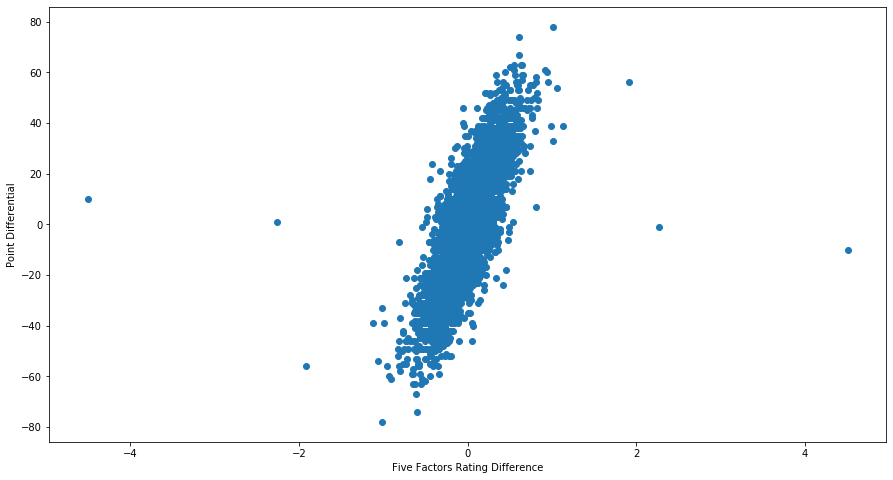

In [57]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [58]:
# Eliminate outliers
# basis = stored_game_boxes[stored_game_boxes['5FRDiff'] != 0]
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [59]:
outliers

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Charlotte,14,-56,0.000059,0.265306,0.040816,3.571429,27.545455,1.272727,0.000000,0.000000,0.000000,0.98,0.00,0.275573,-0.951314,3.267962,2.550343
1,Louisville,70,56,0.999941,0.671875,0.250000,8.375000,31.333333,5.833333,0.888889,0.750000,0.763636,0.98,0.00,1.226887,0.951314,3.267962,2.550343
0,Hawai'i,3,-60,0.000004,0.321429,0.107143,4.303571,27.200000,0.300000,0.250000,0.400000,0.486486,1.20,0.22,0.383199,-0.935409,3.213327,2.732510
1,Michigan,63,60,0.999996,0.706897,0.241379,8.844828,26.750000,7.875000,1.000000,0.875000,0.709091,0.98,-0.22,1.318608,0.935409,3.213327,2.732510
0,Bowling Green,10,-67,0.000005,0.363636,0.054545,3.981818,23.875000,1.250000,0.500000,0.500000,0.410256,0.22,0.00,0.361208,-0.610322,2.096585,3.051303
1,Ohio State,77,67,0.999995,0.674699,0.096386,7.843373,27.800000,7.700000,0.888889,0.900000,0.670886,0.22,0.00,0.971530,0.610322,2.096585,3.051303
0,Bowling Green,3,-74,0.000002,0.338462,0.061538,4.353846,24.583333,0.250000,0.250000,0.333333,0.451613,0.44,0.00,0.306774,-0.603540,2.073288,3.370095
1,Memphis,77,74,0.999998,0.421875,0.171875,6.593750,27.000000,6.416667,1.000000,0.500000,0.550000,0.44,0.00,0.910315,0.603540,2.073288,3.370095
0,Michigan,78,78,0.996516,0.551724,0.172414,9.051724,39.692308,6.000000,1.000000,0.692308,0.680851,0.71,0.22,1.108383,1.017153,3.494133,3.552263
1,Rutgers,0,-78,0.003484,0.142857,0.000000,0.761905,21.076923,0.000000,0.000000,0.000000,0.000000,0.49,-0.22,0.091231,-1.017153,3.494133,3.552263


In [60]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,31,-20,0.008141,0.492958,0.140845,6.591549,22.727273,2.818182,1.000000,0.454545,0.604651,1.69,0.22,0.715955,-0.074703,0.256620,0.910837
1,California,51,20,0.991859,0.523256,0.139535,6.813953,35.500000,4.250000,0.888889,0.750000,0.567568,1.47,-0.22,0.790658,0.074703,0.256620,0.910837
1,Wake Forest,7,4,0.350175,0.360000,0.020000,3.360000,24.444444,0.777778,0.500000,0.222222,0.555556,0.22,0.22,0.329800,0.018632,0.064004,0.182167
0,Appalachian State,13,-7,0.834594,0.367347,0.040816,4.040816,26.818182,1.181818,0.250000,0.363636,0.478261,1.69,-1.10,0.235763,-0.276891,0.951180,0.318793
1,Tennessee,20,7,0.165406,0.353846,0.030769,4.507692,28.600000,2.000000,0.750000,0.400000,0.416667,2.79,1.10,0.512654,0.276891,0.951180,0.318793


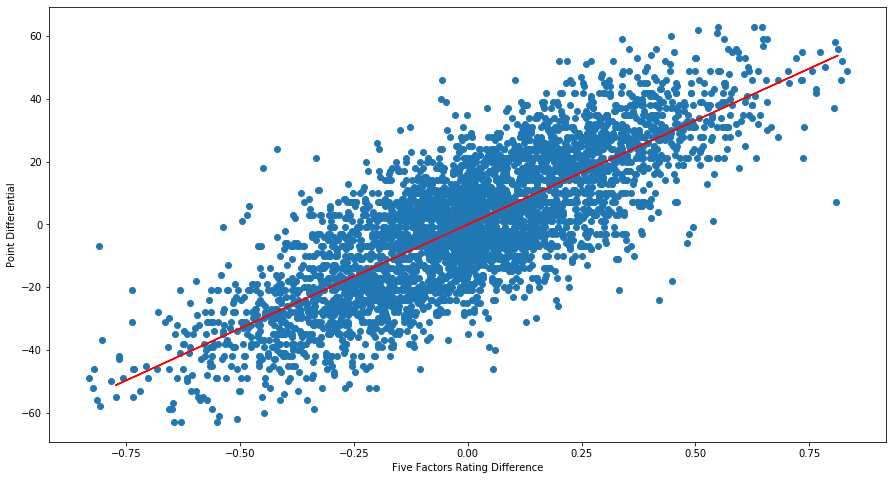

In [61]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [62]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

Linear Regression: y = 66.29421x + -0.04635


In [100]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [101]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3
5FRDiff for Virginia Tech: -0.011872886502929725

Proj MOV by 5FRDiff: Virginia Tech by -1.0 (exact value: -0.8334548134331489)
Z score: -0.06951180824715279
Win Prob for Virginia Tech: 47.23%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.381818,0.072727,4.927273,28.1,3.1,0.75,0.4,0.515152,1.15,0.22,0.547781,0.011873
1,Virginia Tech,34,3,0.124335,0.403226,0.080645,5.629032,26.3,3.4,0.60,0.5,0.487805,0.93,-0.22,0.535908,-0.011873


In [102]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Could not find basic game data for game_id 401112488 locally, checking CFB Data API
Could not find drive data for game_id 401112488 locally, checking CFB Data API
Could not find play by play data for game_id 401112488 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7
5FRDiff for Georgia Tech: -0.15481740014756956

Proj MOV by 5FRDiff: Georgia Tech by -10.0 (exact value: -10.309848306254521)
Z score: -0.6379826744555152
Win Prob for Georgia Tech: 26.17%
Could not find basic game data for game_id 401112488 locally, checking CFB Data API
Could not find drive data for game_id 401112488 locally, checking CFB Data API
Could not find play by play data for game_id 401112488 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,28,7,0.065752,0.376471,0.117647,5.000000,17.444444,3.111111,0.500000,0.444444,0.423077,0.93,-0.66,0.466866,-0.154817
1,Miami,21,-7,0.934248,0.390244,0.121951,5.841463,38.750000,1.750000,0.333333,0.750000,0.411765,1.59,0.66,0.621684,0.154817


In [103]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Could not find basic game data for game_id 401112513 locally, checking CFB Data API
Could not find drive data for game_id 401112513 locally, checking CFB Data API
Could not find play by play data for game_id 401112513 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2
5FRDiff for Georgia Tech: -0.130666867598198

Proj MOV by 5FRDiff: Georgia Tech by -9.0 (exact value: -8.708807848920276)
Z score: -0.5419392950512206
Win Prob for Georgia Tech: 29.39%
Could not find basic game data for game_id 401112513 locally, checking CFB Data API
Could not find drive data for game_id 401112513 locally, checking CFB Data API
Could not find play by play data for game_id 401112513 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,NC State,26,-2,0.156447,0.479167,0.177083,6.12500,23.700000,2.600000,0.833333,0.600000,0.561644,0.98,0.0,0.709716,0.130667
1,Georgia Tech,28,2,0.843553,0.379747,0.126582,5.64557,29.636364,2.545455,0.571429,0.636364,0.454545,0.98,0.0,0.579049,-0.130667


In [104]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Could not find basic game data for game_id 401110863 locally, checking CFB Data API
Could not find drive data for game_id 401110863 locally, checking CFB Data API
Could not find play by play data for game_id 401110863 locally, checking CFB Data API
Actual Winner: Mississippi State
MOV: Mississippi State by 1
5FRDiff for Mississippi State: 0.01594531126833254

Proj MOV by 5FRDiff: Mississippi State by 1.0 (exact value: 1.0107306094293036)
Z score: 0.04111737632370944
Win Prob for Mississippi State: 51.64%
Could not find basic game data for game_id 401110863 locally, checking CFB Data API
Could not find drive data for game_id 401110863 locally, checking CFB Data API
Could not find play by play data for game_id 401110863 locally, checking CFB Data API


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Ole Miss,20,-1,0.384124,0.400000,0.084211,4.800000,25.545455,1.818182,0.60,0.454545,0.470588,1.20,0.22,0.484127,-0.015945
1,Mississippi State,21,1,0.615876,0.369863,0.123288,4.821918,31.333333,1.750000,0.75,0.333333,0.500000,0.98,-0.22,0.500073,0.015945


In [105]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2
5FRDiff for Texas A&M: -0.07251913741311644

Proj MOV by 5FRDiff: Texas A&M by -5.0 (exact value: -4.853950059008152)
Z score: -0.31069369000100566
Win Prob for Texas A&M: 37.80%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,LSU,72,-2,0.321374,0.426230,0.065574,4.639344,26.375,9.000000,0.750000,0.500000,0.489362,0.49,0.0,0.816328,0.072519
1,Texas A&M,74,2,0.678626,0.418919,0.094595,4.621622,28.000,6.727273,0.833333,0.545455,0.517241,0.49,0.0,0.743809,-0.072519
